In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import ellipj, ellipk, ellipkinc, ellipkm1
import axion_motion
import clock_work_axion
import model
import transport_equation
import reheating
from common import constants, cosmology

In [2]:
def sc(x, y):
    sn, cn, _dn, _ph = ellipj(x, y)
    return sn / cn

In [3]:
def calc_f_eff(f, eps):
    return 2 / np.pi * f * ellipkm1(eps**2)

In [4]:
def calc_eps(mR):
    return np.exp(- np.pi * mR)

def calc_m_phi(mR, M):
    return calc_eps(mR) * M

def calc_mass(_T, eps, M):
    return eps * M

def calc_u(phi_over_f, eps):
    return eps * sc(phi_over_f / 2, 1 - eps**2)

def calc_V_eff_over_f_sq(phi_over_f, eps, M):
    return M**2 * 2 / (1 + 1 / calc_u(phi_over_f, eps)**2)

def theta_to_phi_over_f(theta, eps):
    return 2 / eps * ellipkinc(theta / 2, - 1 / eps**2)

In [5]:
def calc_du_dphi_times_f(phi_over_f, eps):
    _sn, cn, dn, _ph = ellipj(phi_over_f / 2, 1 - eps**2)
    return eps / 2 * dn / cn**2

def calc_dV_eff_dphi_over_f(phi_over_f, eps, M):
    u = calc_u(phi_over_f, eps)
    return 4 * M**2 * calc_du_dphi_times_f(phi_over_f, eps) / (u**3 * (1 + 1 / u**2)**2)

In [6]:
def rhs(t, y, eps, M, H_fn):
    phi_over_f, phi_dot_over_f = y
    H = H_fn(t)
    phi_dot_dot_over_f = - 3 * H * phi_dot_over_f - calc_dV_eff_dphi_over_f(phi_over_f, eps, M)
    return phi_dot_over_f, phi_dot_dot_over_f

In [7]:
def rhs_log_t(log_t, y, _T_fn, H_fn, p):
    eps, M = p
    t = np.exp(log_t)
    phi_dot_over_f, phi_dot_dot_over_f = rhs(t, y, eps, M, H_fn)
    return phi_dot_over_f * t, phi_dot_dot_over_f * t

In [8]:
def make_rad_dom_H_fn(t_init, T_init):
    T_fn = lambda t: T_init * (t / t_init)**(-0.5)
    H_fn = lambda t: 1 / (2*t)
    return T_fn, H_fn

In [17]:
def calc_theta_dot(phi_over_f, phi_dot_over_f, eps, M):
    MM = 2*M**2
    A = calc_V_eff_over_f_sq(phi_over_f, eps, M) / MM
    return (
        1 / MM * np.abs(calc_dV_eff_dphi_over_f(phi_over_f, eps, M)) * phi_dot_over_f
        / ((1 - A)*A)**0.5
    )
def get_axion_source_clockwork(field_fn, p):
    eps, M = p
    def source_fn(log_t):
        phi_over_f, phi_dot_over_f = field_fn(log_t)
        return calc_theta_dot(phi_over_f, phi_dot_over_f, eps, M)
    return source_fn

In [18]:
Gamma_phi = 1e7
H_inf = 2e10
mR = 6
m_phi = 100 * 1e-9 # [GeV]
eps = calc_eps(mR)
f = 1e12
f_eff = calc_f_eff(f, eps)
t0, initial = reheating.calc_initial_reheating(H_inf)
tf = t0*1e7
M = m_phi / eps
params = (mR, M)
T_osc = (90 * constants.M_pl**2 * m_phi**2 / (constants.g_star * np.pi**2))**(1/4)

In [19]:
%time T_fn, H_fn, T_dot_fn, final = reheating.solve_reheating_eq(t0, tf, initial, Gamma_phi)

CPU times: user 23.4 ms, sys: 4.38 ms, total: 27.8 ms
Wall time: 19.8 ms


In [22]:
m = model.AxionBaryogenesisModel(
    source_vector=transport_equation.source_vector_weak_sphaleron, 
    get_axion_source=get_axion_source_clockwork,
    axion_rhs=rhs_log_t,
    calc_axion_mass=calc_mass,
    axion_parameter=(eps, M),
    axion_initial=(theta_to_phi_over_f(1.0, eps), 0),
    Gamma_phi=Gamma_phi,
    H_inf=H_inf,
)
res = model.solve(m, collect=True)

<ipython-input-7-a3c7de6667fc>:3: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)


<ipython-input-24-0aead7bd945d>:20: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6


name 'root' is not defined
name 'root' is not defined
name 'root' is not defined
name 'root' is not defined
name 'root' is not defined
name 'root' is not defined
name 'root' is not defined
name 'root' is not defined
name 'root' is not defined
name 'root' is not defined


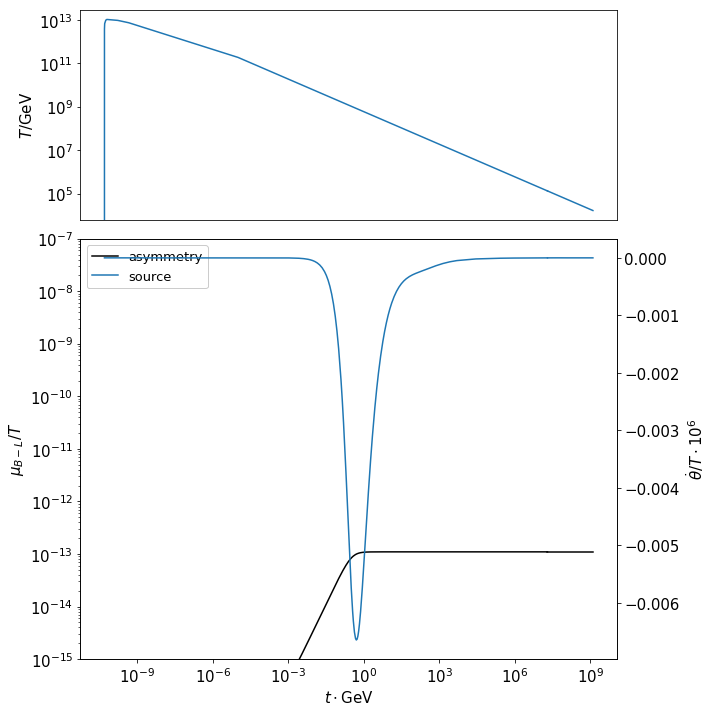

In [25]:
plot(res)

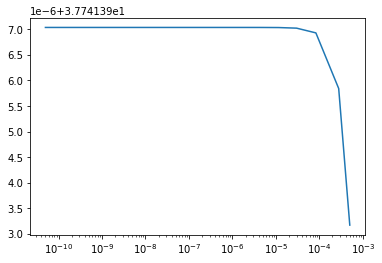

In [26]:
def evolve(t_start, t_end, initial, args, steps=None):
    sol = solve_ivp(rhs, (t_start, t_end), initial, t_eval=steps, method="Radau", args=args)
    assert sol.success
    return sol

sol_sbg = evolve(t0, tf, (theta_to_phi_over_f(1.0, eps), 0), (eps, M, H_fn))
plt.semilogx(sol_sbg.t, sol_sbg.y[0])

Text(0, 0.5, 'V_eff / GeV^4')

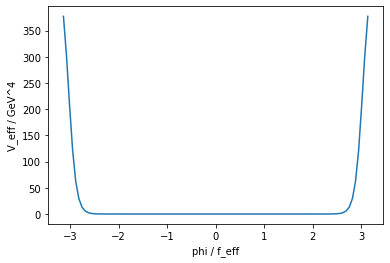

In [27]:
theta_range = np.linspace(-np.pi, np.pi, 100)
phi_over_f_range = f_eff * theta_range / f # not a linear map
plt.plot(theta_range, calc_V_eff_over_f_sq(phi_over_f_range, eps, M))
plt.xlabel("phi / f_eff")
plt.ylabel("V_eff / GeV^4")

In [28]:
t_osc = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_entropy_density(T_osc)))

In [30]:
"%e" % t_osc

'2.236517e+09'

In [ ]:
T_fn_rad_dom, H_fn_rad_dom = make_rad_dom_H_fn(tf, T_fn(tf))

In [ ]:
sol_relic = evolve(tf, t_osc, sol_sbg.y[:, -1], (eps, M, H_fn_rad_dom))
plt.semilogx(sol_relic.t, sol_relic.y[0])

In [ ]:
def calc_abundance(phi_over_f, phi_dot_over_f, T, eps, f, M):
    rho = f**2 * (0.5 * phi_dot_over_f**2 + calc_V_eff_over_f_sq(phi_over_f, eps, M))
    n = rho / m_phi
    s = cosmology.calc_entropy_density(T)
    return n / s

In [ ]:
Y = calc_abundance(*sol_relic.y, T_fn_rad_dom(sol_relic.t), eps, f, M)
plt.loglog(sol_relic.t, Y)
plt.xlabel("t * GeV")
plt.ylabel("Y")

In [ ]:
def compute_relic_density(field_initial_over_f, T_initial, t_initial, f, mR, M, 
                          num_osc_per_step=10, convergence_epsilon=1e-3, debug=False):
    T_fn_rad_dom, H_fn_rad_dom = make_rad_dom_H_fn(t_initial, T_initial)
    m_phi = calc_m_phi(mR, M)
    t_osc = cosmology.switch_hubble_and_time_rad_dom(m_phi)
    Delta_t = 2*np.pi / m_phi * num_osc_per_step 
    eps = calc_eps(mR)
    args = (eps, M, H_fn)
    sol = evolve(t_initial, t_osc, field_initial_over_f, args)
    change = 1
    while change > convergence_epsilon:
        t_start = sol.t[-1]
        t_end = t_start + Delta_t
        t_steps = np.linspace(t_start, t_end, num_osc_per_step * 10)
        t_steps[0] = t_start; t_steps[-1] = t_end
        sol = evolve(t_start, t_end, sol.y[:, -1], args, steps=t_steps)
        Y = calc_abundance(*sol.y, T_fn(sol.t), eps, f, M)
        Y_max, Y_min = np.max(Y), np.min(Y)
        change = Y_max - Y_min
        if debug:
            print("change:", change, "Y_mean:", Y_mean, "convergence_eps:", convergence_epsilon)
    Y = (Y_max + Y_min) / 2
    n_today = Y * cosmology.calc_entropy_density(constants.T_CMB)
    rho_today = m_phi * n_today
    Omega_h_sq = rho_today / constants.rho_c * constants.h**2
    return Omega_h_sq

In [ ]:
compute_relic_density(sol_sbg.y[:, -1], T_fn(sol_sbg.t[-1]), sol_sbg.t[-1], f, mR, M)